In [2]:
from gluonts.dataset.field_names import FieldName

[f"FieldName.{k} = '{v}'" for k, v in FieldName.__dict__.items() if not k.startswith('_')]

["FieldName.ITEM_ID = 'item_id'",
 "FieldName.START = 'start'",
 "FieldName.TARGET = 'target'",
 "FieldName.FEAT_STATIC_CAT = 'feat_static_cat'",
 "FieldName.FEAT_STATIC_REAL = 'feat_static_real'",
 "FieldName.FEAT_DYNAMIC_CAT = 'feat_dynamic_cat'",
 "FieldName.FEAT_DYNAMIC_REAL = 'feat_dynamic_real'",
 "FieldName.PAST_FEAT_DYNAMIC_REAL = 'past_feat_dynamic_real'",
 "FieldName.FEAT_DYNAMIC_REAL_LEGACY = 'dynamic_feat'",
 "FieldName.FEAT_DYNAMIC = 'feat_dynamic'",
 "FieldName.PAST_FEAT_DYNAMIC = 'past_feat_dynamic'",
 "FieldName.FEAT_TIME = 'time_feat'",
 "FieldName.FEAT_CONST = 'feat_dynamic_const'",
 "FieldName.FEAT_AGE = 'feat_dynamic_age'",
 "FieldName.OBSERVED_VALUES = 'observed_values'",
 "FieldName.IS_PAD = 'is_pad'",
 "FieldName.FORECAST_START = 'forecast_start'",
 "FieldName.TARGET_DIM_INDICATOR = 'target_dimension_indicator'"]

In [3]:
import numpy as np

def create_dataset(num_series, num_steps, period=24, mu=1, sigma=0.3):
    # create target: noise + pattern
    # noise
    noise = np.random.normal(mu, sigma, size=(num_series, num_steps))

    # pattern - sinusoid with different phase
    sin_minumPi_Pi = np.sin(np.tile(np.linspace(-np.pi, np.pi, period), int(num_steps / period)))
    sin_Zero_2Pi = np.sin(np.tile(np.linspace(0, 2 * np.pi, 24), int(num_steps / period)))

    pattern = np.concatenate((np.tile(sin_minumPi_Pi.reshape(1, -1),
                                      (int(np.ceil(num_series / 2)),1)),
                              np.tile(sin_Zero_2Pi.reshape(1, -1),
                                      (int(np.floor(num_series / 2)), 1))
                             ),
                             axis=0
                            )

    target = noise + pattern

    # create time features: use target one period earlier, append with zeros
    feat_dynamic_real = np.concatenate((np.zeros((num_series, period)),
                                        target[:, :-period]
                                       ),
                                       axis=1
                                      )

    # create categorical static feats: use the sinusoid type as a categorical feature
    feat_static_cat = np.concatenate((np.zeros(int(np.ceil(num_series / 2))),
                                      np.ones(int(np.floor(num_series / 2)))
                                     ),
                                     axis=0
                                    )

    return target, feat_dynamic_real, feat_static_cat

In [4]:
import pandas as pd

# define the parameters of the dataset
custom_ds_metadata = {'num_series': 100,
                      'num_steps': 24 * 7,
                      'prediction_length': 24,
                      'freq': '1H',
                      'start': [pd.Timestamp("01-01-2019", freq='1H')
                                for _ in range(100)]
                     }

In [5]:
data_out = create_dataset(custom_ds_metadata['num_series'],
                          custom_ds_metadata['num_steps'],
                          custom_ds_metadata['prediction_length']
                         )

target, feat_dynamic_real, feat_static_cat = data_out

In [5]:
from gluonts.dataset.common import ListDataset

train_ds = ListDataset([{FieldName.TARGET: target,
                         FieldName.START: start,
                         FieldName.FEAT_DYNAMIC_REAL: [fdr],
                         FieldName.FEAT_STATIC_CAT: [fsc]}
                        for (target, start, fdr, fsc) in zip(target[:, :-custom_ds_metadata['prediction_length']],
                                                             custom_ds_metadata['start'],
                                                             feat_dynamic_real[:, :-custom_ds_metadata['prediction_length']],
                                                             feat_static_cat)],
                      freq=custom_ds_metadata['freq'])

In [6]:
test_ds = ListDataset([{FieldName.TARGET: target,
                        FieldName.START: start,
                        FieldName.FEAT_DYNAMIC_REAL: [fdr],
                        FieldName.FEAT_STATIC_CAT: [fsc]}
                       for (target, start, fdr, fsc) in zip(target,
                                                            custom_ds_metadata['start'],
                                                            feat_dynamic_real,
                                                            feat_static_cat)],
                     freq=custom_ds_metadata['freq'])

In [9]:
train_entry = next(iter(train_ds))
train_entry.keys()

test_entry = next(iter(test_ds))
test_entry.keys()

dict_keys(['target', 'start', 'feat_dynamic_real', 'feat_static_cat', 'source'])

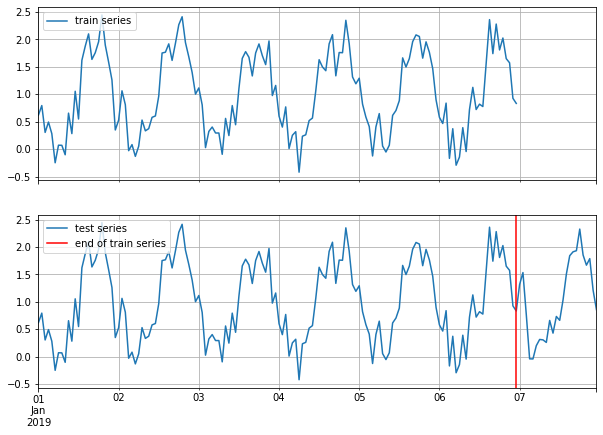

In [10]:
import matplotlib.pyplot as plt
from gluonts.dataset.util import to_pandas

test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [11]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.mx.trainer import Trainer

estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=custom_ds_metadata['prediction_length'],
    context_length=2*custom_ds_metadata['prediction_length'],
    freq=custom_ds_metadata['freq'],
    trainer=Trainer(ctx="cpu",
                    epochs=5,
                    learning_rate=1e-3,
                    hybridize=False,
                    num_batches_per_epoch=100
                   )
)

In [12]:
predictor = estimator.train(train_ds)

Multiprocessing is not supported on Windows, num_workers will be set to None.
100%|██████████| 100/100 [00:00<00:00, 136.72it/s, epoch=5/5, avg_epoch_loss=0.623]


learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


In [14]:
from gluonts.evaluation.backtest import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

forecast_entry = forecasts[0]
ts_entry = tss[0]

In [15]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

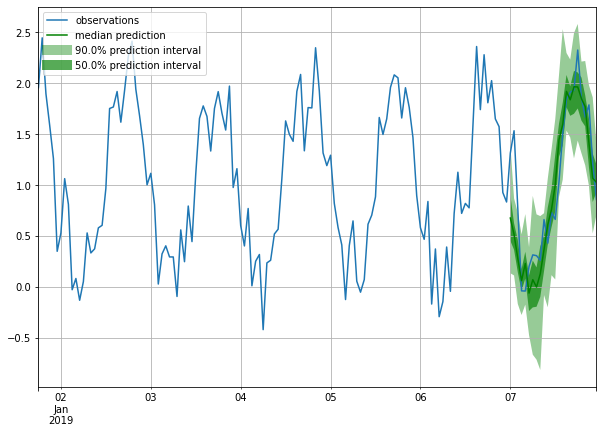

In [16]:
plot_prob_forecasts(ts_entry, forecast_entry)